# Hierarchical matrices - H matrices

In [1]:
using Plots,LinearAlgebra
pyplot()

Plots.PyPlotBackend()

As matrizes de influência $\boldsymbol{H}$ e $\boldsymbol{G}$ para os elementos e pontos fontes dados será aproximada por polinômios de Lagrage e separação de variáveis. Essa é uma aproximação de baixo rank que será utilizada junto com a divisão binária baseada em matrizes hierárquicas para fazer a aproximação de blocos das matrizes de influência quando os pontos fontes se encontram distantes dos elementos.

In [33]:
# Cubo de lado LL
LL = 1
NOS_GEO = [ 0   LL 0                                               
            LL  LL 0                                               
            0   LL LL                                              
            LL  LL LL];                                            
                                                                          
# Matriz de conectividade (nós que definem os elementos)                  
# ELEM = [número do elemento, no1, no2, no3, face]                        
ELEM = [   1   4   2   1                                                 
           1   3   4   1];
b2 = [1 2];
PONTOS_dom1 = [];
passo = 0.05;
[append!(PONTOS_dom1,[i*passo -1 j*passo] for i=1:10,j=1:10)];
[append!(PONTOS_dom1,[i*passo -0.7 j*passo] for i=1:10,j=1:10)];
PONTOS_dom = zeros(size(PONTOS_dom1,1),3);
[PONTOS_dom[i,:] = PONTOS_dom1[i] for i = 1:size(PONTOS_dom1,1)];
b1 = collect(1:size(PONTOS_dom,1));

Dois elementos e duzentos pontos fonte serão utilizados nessa demonstração.

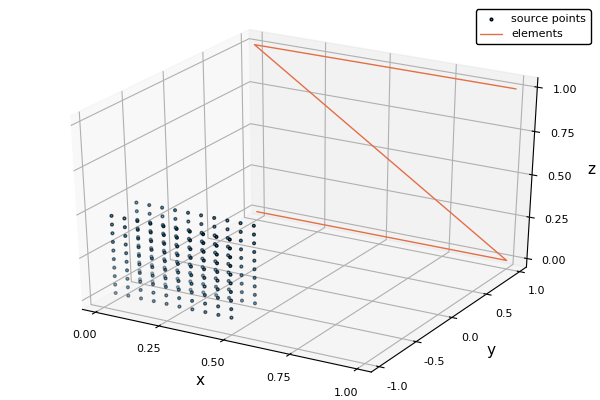

In [117]:
pyplot()
plot(PONTOS_dom[:,1],PONTOS_dom[:,2],PONTOS_dom[:,3],line=0,marker=(2,2.0,:o),label="source points")
plot!(NOS_GEO[:,1],NOS_GEO[:,2],NOS_GEO[:,3],label="elements",xlabel="x",ylabel="y",zlabel="z")

In [35]:
function criapontosinterp(n)
    x= cos.((2. .*(1:n) .-1).*pi./2. ./n)
end

criapontosinterp (generic function with 1 method)

In [36]:
function calc_fforma(qsi)                                 
  # Calcula as funções de forma lineares contínuas N1 e N2
  N1=1. /2. .*(1. .-qsi); # Função de forma N1 => linear contínua
  N2=1. /2. .*(1. .+qsi); # Função de forma N2 => linear contínua
return N1,N2
end                                                                       
                                                                          
function calc_fformatri(qsi,eta)
    N1 = qsi;                                                             
    N2 = eta;                                                             
    N3 = 1 .-qsi .-eta;                                                                      
return N1,N2,N3                                                           
end 
function calc_dfforma(qsi, eta)

dNdqsi = [1 0 -1]

dNdeta = [0 1 -1]
return dNdqsi, dNdeta
end

calc_dfforma (generic function with 1 method)

In [37]:
function calc_jacobiano(x1,y1,z1,x2,y2,z2,x3,y3,z3,qsi,eta)
dNdqsi, dNdeta = calc_dfforma(qsi,eta); # Calcula a derivada das fun��es
  # de forma
dxdqsi = x1 .*dNdqsi[1].+ x2.*dNdqsi[2].+x3.*dNdqsi[3]
dydqsi = y1.*dNdqsi[1].+y2.*dNdqsi[2].+y3.*dNdqsi[3]
dzdqsi = z1.*dNdqsi[1].+z2.*dNdqsi[2].+z3.*dNdqsi[3]

dxdeta = x1.*dNdeta[1].+x2.*dNdeta[2].+x3.*dNdeta[3]
dydeta = y1.*dNdeta[1].+y2.*dNdeta[2].+y3.*dNdeta[3]
dzdeta = z1.*dNdeta[1].+z2.*dNdeta[2].+z3.*dNdeta[3]

g1 = dydqsi.*dzdeta .- dzdqsi.*dydeta;
g2 = dzdqsi.*dxdeta .- dxdqsi.*dzdeta;
g3 = dxdqsi.*dydeta .- dydqsi.*dxdeta;
J = sqrt(g1.^2.0 + g2.^2.0 + g3.^2.0);

return J
end

calc_jacobiano (generic function with 1 method)

In [38]:
function calc_vetnormal(x1,y1,z1,x2,y2,z2,x3,y3,z3)
    # Function que calcula o vetor unit�rio normal ao elemento

    v1 = [x3,y3,z3] .- [x2,y2,z2]; # vetor formado pela aresta 32 do elemento
    v2 = [x1,y1,z1] .- [x2,y2,z2]; # vetor formado pela aresta 12 do elemento
    n = cross(v1, v2); # Produto vetorial entre v1 e v2 (vetor normal ao
    # elemento)
    #println(v1,v2,n)
    if sum(abs.(n)) > 0.000001
	n = n./norm(n); # vetor unit�rio normal ao elemento
    end
    #println(v1,v2,n)
    return n
end


calc_vetnormal (generic function with 1 method)

In [39]:
function lagrange(pg,x,n)
    ni = length(pg);
    L = ones(ni,n);
    for j = 1:n
        for i = 1:n
            if (i != j)
                L[:,j] = L[:,j].*(pg .- x[i])/(x[j]-x[i]);
            end
        end
    end
    return L
end

function lagrange(pg,x1,n1,x2,n2)
    l1=lagrange(pg[:,1],x1,n1)
    l2=lagrange(pg[:,2],x2,n2)
    ni=size(pg,1)
    L=zeros(ni,n1*n2)
    for i=1:ni
        L[i,:]=(l1[i,:]*l2[i,:]')[:]
    end
    L
end

function lagrange(pg,x1,n1,x2,n2,x3,n3)                                   
    l1=lagrange(pg[:,1:2],x1,n1,x2,n2)                                    
    l2=lagrange(pg[:,3],x3,n3)                                            
                                                                          
                                                                          
    ni=size(pg,1)                                                         
    L=zeros(ni,n1*n2*n3)                                                  
    for i=1:ni                                                            
        L[i,:]=(l1[i,:]*l2[i,:]')[:]                                      
    end                                                                   
    L                                                                     
end 

lagrange (generic function with 3 methods)

In [40]:
function Gauss_Legendre(x1,x2,n)
x = zeros(n);
w = zeros(n);
pp=0; # inicializando variável pp
eps=3e-14;
m=round(Int,(n+1)/2);
xm=.5*(x2+x1);
xl=.5*(x2-x1);
for i=1:m
    z=cos(pi*(i-.25)/(n+.5));
    while 1==1
        p1=1.;
        p2=0.;
        for j=1:n
            p3=p2;
            p2=p1;
            p1=((2*j-1)*z*p2-(j-1)*p3)/j;
        end
        pp=n*(z*p1-p2)/(z*z-1);
        z1=z;
        z=z1-p1/pp;
        if(abs(z-z1)<eps)
            break
        end
    end
    x[i]=xm-xl*z;
    x[n+1-i]=xm+xl*z;
    w[i]=2*xl/((1-z*z)*pp*pp);
    w[n+1-i]=w[i];
end 
return x,w
end

Gauss_Legendre (generic function with 1 method)

In [41]:
function calc_solfund(x,y,z,xd,yd,zd,n,k)
    # Evaluates the fundamental solutions of the Helmholtz equation.
    # Determine the distance between source and field points
    rx=x-xd;
    ry=y-yd;
    rz=z-zd;
    r =sqrt(rx^2+ry^2+rz^2);
    ZW=complex(0.,k*r);
    U=exp(ZW)/complex(4*pi*r,0.); # Fundamental solution for the velocity potential
    drdn=(rx*n[1] + ry*n[2] + rz*n[3])/r;	# Unit normal derivative of the distance
    Q=(ZW-complex(1.,0.))*U*complex(drdn/r,0.); # Fundamental solution for the flux
    return U,Q
end
function calc_solfund_POT(x,y,z,xd,yd,zd,n,k)
    rx=x-xd;
    ry=y-yd;
    rz=z-zd;
    r =sqrt(rx^2+ry^2+rz^2);
    Tast = 1.0/(4.0*pi*r);
    qast = (rx*n[1] + ry*n[2] + rz*n[3])/(4.0*pi*r^3.0);
    return Tast, qast
end

calc_solfund_POT (generic function with 1 method)

In [42]:

function calcula_HeGns_POT(x1,y1,z1,x2,y2,z2,x3,y3,z3,xd,yd,zd,n,qsil,w,k)
    #integra��o n�o singular
    n_pint=length(qsil); # N�mero de pontos de integra��o.
    g=0; # Inicializa o somatorio de g
    h=0; # Inicializa o somatorio de h

    eta = qsil;
    rho = w;
    Tast = complex(0,0);
    qast = complex(0,0);

    for l=1:n_pint # La�o sobre os pontos de integra��o
        for m=1:n_pint # La�o sobre os pontos de integra��o

            qsi=(1-eta[l])*qsil[m];

            N1,N2,N3=calc_fformatri(qsi,eta[l]); #  fun��es de forma
            x=N1*x1+N2*x2+N3*x3; # coordenada x do ponto de integra��o
            y=N1*y1+N2*y2+N3*y3; # coordenada y do ponto de integra��o
            z=N1*z1+N2*z2+N3*z3; # coordenada z do ponto de integra��o

            dNdqsi = [1; 0; -1]; # Derivadas das fun��es de forma
            dNdeta = [0; 1; -1];

            dxdqsi = x1*dNdqsi[1]+x2*dNdqsi[2]+x3*dNdqsi[3];
            dydqsi = y1*dNdqsi[1]+y2*dNdqsi[2]+y3*dNdqsi[3];
            dzdqsi = z1*dNdqsi[1]+z2*dNdqsi[2]+z3*dNdqsi[3];

            dxdeta = x1*dNdeta[1]+x2*dNdeta[2]+x3*dNdeta[3];
            dydeta = y1*dNdeta[1]+y2*dNdeta[2]+y3*dNdeta[3];
            dzdeta = z1*dNdeta[1]+z2*dNdeta[2]+z3*dNdeta[3];

            g1 = dydqsi*dzdeta - dzdqsi*dydeta;
            g2 = dzdqsi*dxdeta - dxdqsi*dzdeta;
            g3 = dxdqsi*dydeta - dydqsi*dxdeta;
            J = sqrt(g1^2.0 + g2^2.0 + g3^2.0);

            Tast,qast=calc_solfund_POT(x,y,z,xd,yd,zd,n,k); # Solu��es fundamentais

            h=h+qast*(1-eta[l])*rho[l]*w[m]*J; # Integral da matriz H
            g=g+Tast*(1-eta[l])*rho[l]*w[m]*J; # Integral da matriz G

        end
    end
    return g,h
end


calcula_HeGns_POT (generic function with 1 method)

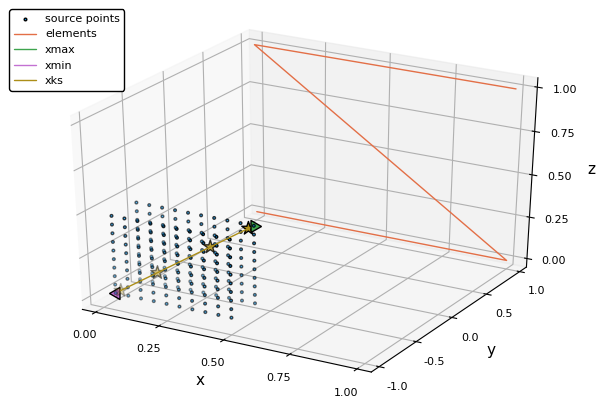

In [112]:
xmax=zeros(1,3)
xmin=zeros(1,3)
xmax[1]=maximum(PONTOS_dom[b1,1])
xmin[1]=minimum(PONTOS_dom[b1,1])
xmax[2]=maximum(PONTOS_dom[b1,2])
xmin[2]=minimum(PONTOS_dom[b1,2])
xmax[3]=maximum(PONTOS_dom[b1,3])
xmin[3]=minimum(PONTOS_dom[b1,3])
ninterp = 4
xs=criapontosinterp(ninterp)
xint=zeros(ninterp*ninterp*ninterp,3)
n1,n2=calc_fforma(xs)
xks=n1 .*xmax .+ n2 .*xmin
npg=4
xi,w=Gauss_Legendre(0,1,npg)
plot(PONTOS_dom[:,1],PONTOS_dom[:,2],PONTOS_dom[:,3],line=0,marker=(2,2.0,:o),label="source points")
plot!(NOS_GEO[:,1],NOS_GEO[:,2],NOS_GEO[:,3],label="elements",camera=[45 45 45])
plot!([xmax[1]],[xmax[2]],[xmax[3]],marker=(2,10.0,:>),label="xmax",xlabel="x",ylabel="y",zlabel="z")
plot!([xmin[1]],[xmin[2]],[xmin[3]],marker=(2,10.0,:<),label="xmin")
plot!(xks[:,1],xks[:,2],xks[:,3],marker=(2,10.0,:s),label="xks",camera=[30])

In [113]:
ϵ=1e-6
GG = (zeros(ninterp*ninterp*ninterp,length(b2)))      # Dimensiona matriz G
HH = (zeros(ninterp*ninterp*ninterp,length(b2)))      # Dimensiona matriz H
xyz = zeros(ninterp*ninterp*ninterp,3)      # Dimensiona matriz H
k=1
ci=0
for i3 =1:ninterp # Laco sobre os pontos fontes
for i2 =1:ninterp # Laco sobre os pontos fontes
    for i1 =1:ninterp # Laco sobre os pontos fontes
        ci+=1
        xd=xks[i1,1]; # Coordenada x do ponto fonte
        yd=xks[i2,2]; # Coordenada y do ponto fonte
        zd=xks[i3,3]; # Coordenada y do ponto fonte
        xyz[ci,:]=[xd yd zd]
        xint[ci,:]=[xd yd zd]
        cj=0       
        for j in b2 # Laco sobre os elementos
            cj+=1
            no1::Int64=ELEM[j,1]; # Ponto inicial do elemento
            no2::Int64=ELEM[j,2]; # Ponto final do elemento
            no3::Int64=ELEM[j,3]; # Ponto final do elemento
            x1=NOS_GEO[no1,1]; # Coordenada x do ponto inicial do elemento
            x2=NOS_GEO[no2,1]; # Coordenada x do ponto final do elemento
            x3=NOS_GEO[no3,1]; # Coordenada x do ponto final do elemento
            y1=NOS_GEO[no1,2]; # Coordenada y do ponto inicial do elemento
            y2=NOS_GEO[no2,2];  # Coordenada y do ponto final do elemento
            y3=NOS_GEO[no3,2];  # Coordenada y do ponto final do elemento
            z1=NOS_GEO[no1,3]; # Coordenada z do ponto inicial do elemento
            z2=NOS_GEO[no2,3];  # Coordenada  do ponto final do elemento
            z3=NOS_GEO[no3,3];  # Coordenada z do ponto final do elemento
            n = calc_vetnormal(x1,y1,z1,x2,y2,z2,x3,y3,z3); 
            g=0
            h=0
            for l =1:npg
            for m =1:npg
                qsi = (1 - xi[l])*xi[m]
                N =calc_fformatri(qsi,xi[l]); #  fun��es de forma
                x=N[1]*x1+N[2]*x2+N[3]*x3; # coordenada x do ponto de integra��o
                y=N[1]*y1+N[2]*y2+N[3]*y3 # coordenada y do ponto de integra��o
                z=N[1]*z1+N[2]*z2+N[3]*z3; # coordenada z do ponto de integra��o
                J = calc_jacobiano(x1,y1,z1,x2,y2,z2,x3,y3,z3,qsi,xi[m]);# jacobiano
                Tast,qast=calc_solfund_POT(x,y,z,xd,yd,zd,n,k); # Solu��es
                g=g+Tast*complex((1-xi[l])*w[l]*w[m]*J,0); # Integral da matriz G
                h=h+qast*complex((1-xi[l])*w[l]*w[m]*J,0); # Integral da matriz H
            end
            end
            GG[ci,cj] = g
            HH[ci,cj] = h
        end
    end
end
end
if abs(xmax[1]-xmin[1])<ϵ && abs(xmax[2]-xmin[2])>=ϵ && abs(xmax[3]-xmin[3])>=ϵ
    fontes=[(2. .*(PONTOS_dom[b1,2] .-xmin[2])./(xmax[2]-xmin[2]).-1) (2. .*(PONTOS_dom[b1,3] .-xmin[3])./(xmax[3]-xmin[3]).-1)];
    LL=lagrange(fontes,xs,ninterp,xs,ninterp);
    L=[LL LL]./2;
elseif abs(xmax[2]-xmin[2])<ϵ && abs(xmax[1]-xmin[1])>=ϵ && abs(xmax[3]-xmin[3])>=ϵ
    fontes=(2. .*(PONTOS_dom[b1,1] .-xmin[1])./(xmax[1]-xmin[1]).-1);
    LL=lagrange(fontes,xs,ninterp,xs,ninterp);
    L=[LL LL]./2;
elseif abs(xmax[3]-xmin[3])<ϵ && abs(xmax[2]-xmin[2])>=ϵ && abs(xmax[1]-xmin[1])>=ϵ
    fontes=(2. .*(PONTOS_dom[b1,1] .-xmin[1])./(xmax[1]-xmin[1]).-1);
    LL=lagrange(fontes,xs,ninterp,xs,ninterp);
    L=[LL LL]./2;
elseif abs(xmax[2]-xmin[2])<ϵ && abs(xmax[3]-xmin[3]) < ϵ && abs(xmax[1]-xmin[1])>=ϵ
    fontes=(2. .*(PONTOS_dom[b1,1] .-xmin[1])./(xmax[1]-xmin[1]).-1);
    LL=lagrange(fontes,xs,ninterp);
    L=[LL LL LL]./3;
elseif abs(xmax[2]-xmin[2])<ϵ && abs(xmax[1]-xmin[1]) < ϵ && abs(xmax[2]-xmin[2])>=ϵ
    fontes=(2. .*(PONTOS_dom[b1,3] .-xmin[3])./(xmax[3]-xmin[3]).-1);
    LL=lagrange(fontes,xs,ninterp);
    L=[LL LL LL]./3;
elseif abs(xmax[1]-xmin[1])<ϵ && abs(xmax[3]-xmin[3]) < ϵ && abs(xmax[2]-xmin[2])>=ϵ
    fontes=(2. .*(PONTOS_dom[b1,2] .-xmin[2])./(xmax[2]-xmin[2]).-1);
    LL=lagrange(fontes,xs,ninterp);
    L=[LL LL LL]./3;
else
    fontes=[(2. .*(PONTOS_dom[b1,1] .- xmin[1]) ./(xmax[1]-xmin[1]).-1) (2. .*(PONTOS_dom[b1,2] .-xmin[2])./(xmax[2]-xmin[2]).-1)  (2. .*(PONTOS_dom[b1,3] .-xmin[3])./(xmax[3]-xmin[3]).-1)];
    L=lagrange(fontes,xs,ninterp,xs,ninterp,xs,ninterp);
    end;
L=reverse(L,dims=1);

In [114]:
    nnos = length(b1);
    nelem = length(b2)
    G=zeros(nnos,nelem); 
    H=zeros(nnos,nelem);     
    ci=0
    for i in b1
        ci+=1
        xd=PONTOS_dom[i,1]; 
        yd=PONTOS_dom[i,2]; 
        zd=PONTOS_dom[i,3];
        cj=0
        for j in b2
            cj+=1
            nos = ELEM[j,1:3];

            no1=ELEM[j,1]; 
            no2=ELEM[j,2]; 
            no3=ELEM[j,3]; 

            x1=NOS_GEO[no1,1]; 
            y1=NOS_GEO[no1,2]; 
            z1=NOS_GEO[no1,3]; 

            x2=NOS_GEO[no2,1]; 
            y2=NOS_GEO[no2,2]; 
            z2=NOS_GEO[no2,3]; 

            x3=NOS_GEO[no3,1]; 
            y3=NOS_GEO[no3,2]; 
            z3=NOS_GEO[no3,3]; 

            n = calc_vetnormal(x1,y1,z1,x2,y2,z2,x3,y3,z3); 
            
            G[ci,cj],H[ci,cj]=calcula_HeGns_POT(x1,y1,z1,x2,y2,z2,x3,y3,z3,xd,yd,zd,n,xi,w,k); 
        end
    end

In [115]:
GH = L*GG
println("GH  G  (GH-G)")
[GH[:,1] G[:,1] GH[:,1].-G[:,1]]

GH  G  (GH-G)


200×3 Array{Float64,2}:
 0.0186565  0.0186567  -2.06076e-7
 0.0187743  0.0187744  -8.28074e-8
 0.0188839  0.018884   -1.02892e-7
 0.0189849  0.018985   -1.75591e-7
 0.0190768  0.019077   -2.34497e-7
 0.0191593  0.0191596  -2.42201e-7
 0.0192321  0.0192323  -1.94816e-7
 0.0192948  0.0192949  -1.26272e-7
 0.019347   0.0193471  -1.12299e-7
 0.0193883  0.0193885  -2.74e-7   
 0.0187059  0.0187059  -1.72706e-8
 0.0188248  0.0188247   1.11998e-7
 0.0189354  0.0189353   9.67982e-8
 ⋮                                
 0.0227512  0.022751    2.72787e-7
 0.0228206  0.0228206  -1.51721e-8
 0.0215947  0.0215951  -3.48396e-7
 0.0217787  0.0217789  -1.53222e-7
 0.0219511  0.0219513  -1.85816e-7
 0.0221111  0.0221114  -3.06516e-7
 0.0222579  0.0222584  -4.07245e-7
 0.0223909  0.0223913  -4.23039e-7
 0.0225091  0.0225094  -3.43648e-7
 0.0226118  0.022612   -2.24964e-7
 0.0226983  0.0226985  -1.99981e-7
 0.0227677  0.0227681  -4.89022e-7

In [116]:
println("GH  G  (GH-G)")
[GH[:,2] G[:,2] GH[:,2].-G[:,2]]

GH  G  (GH-G)


200×3 Array{Float64,2}:
 0.0186565  0.0186567  -2.06072e-7
 0.0187059  0.0187059  -1.72785e-8
 0.0187453  0.0187453  -3.89111e-8
 0.0187746  0.0187748  -1.31818e-7
 0.018794   0.0187942  -2.01925e-7
 0.0188033  0.0188035  -2.01667e-7
 0.0188025  0.0188026  -1.3083e-7 
 0.0187915  0.0187916  -3.68033e-8
 0.0187704  0.0187704  -1.42362e-8
 0.0187391  0.0187393  -2.0411e-7 
 0.0187743  0.0187744  -8.28022e-8
 0.0188248  0.0188247   1.11989e-7
 0.0188651  0.018865    9.00704e-8
 ⋮                                
 0.0227512  0.022751    2.72695e-7
 0.0226982  0.0226984  -1.99926e-7
 0.0226021  0.0226026  -4.84321e-7
 0.0226909  0.0226909  -1.93128e-8
 0.0227623  0.0227624  -7.28619e-8
 0.0228163  0.0228166  -3.03439e-7
 0.0228527  0.0228532  -4.78282e-7
 0.0228714  0.0228719  -4.78725e-7
 0.0228724  0.0228727  -3.0358e-7 
 0.0228555  0.0228556  -7.04862e-8
 0.0228206  0.0228206  -1.52063e-8
 0.0227677  0.0227681  -4.88909e-7